# Übung 07 : Entscheidungsbäume

Wie üblich importieren wir zuerst unsere Standardbibliotheken

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Aufgabe 1: Entscheidungsbaum
### 1.1 Funktionsweise
In dieser Aufgabe beschäftigen wir uns noch einmal mit der grundsätzlichen Funktion eines Entscheidungsbaumes, indem wir grundlegende Teilfunktionen selbst implementieren.
Danach schauen wir uns ein kleines Beispiel anhand des in scikit-learn implementierten **DecisionTree** an.

Wir wollen uns zu Anfang das folgende (nicht realistische) Beispiel anschauen:

Wir möchten auf Basis einfacher Ja/Nein Fragen vorhersagen, ob eine Herzerkrankung vorliegt.


Brustschmerzen | Blutzirkulation| Arterien| Herzerkrankung
---------------|----------------|---------|--------------
Ja             |Schlecht        |Blockiert| Nein
Ja             |Gut             |Frei     |Ja
Nein           |Schlecht        |Frei     |Nein
Ja             |Gut             |Blockiert|Ja



Die Tabelle ist auch als numpy Array gegeben.

In [49]:
data = np.array((1,0,0,0,1,1,1,1,0,0,1,0,1,1,0,1)).reshape(4,4)
print(data)

[[1 0 0 0]
 [1 1 1 1]
 [0 0 1 0]
 [1 1 0 1]]


Wir haben 3 Merkmale und sehen auf den ersten Blick, dass das 2. Merkmal unsere beiden Klassen perfekt trennt.
Diese Erkenntnis können wir nutzen um zu prüfen, ob unsere Algorithmus funktioniert.

a) Implementiere die Funktion `gini_2class`, welche die weighted Gini-Impurity für gegebene Trennungen der Labels nach einem Merkmal berechnet.

In [3]:
def gini_2class(split_y,split_n):
  """
  Berechnet die Gini-Impurity für einen Knoten/einen Split der Daten. Bekommt resultierende Labels.
  Parameter
  ------
  split_y: ndarray der Gestalt (n_y_samples,1), labels an der linken Abzweigung des Knotens
  split_n: ndarray der Gestalt (n_n_samples,1), labels an der rechten Abzweigung des Knotens

  returns
  ----
  wgi:  weighted Gini-Impurity
  """
  T_y =split_y.sum()
  T_n = split_n.sum()
  n_y = split_y.shape[0]
  n_n = split_n.shape[0]
  if n_y==0 or n_n==0:
    return 1.1 # fängt Problem der threshold Berechnung ab (threshold identisch zu Datum, da Sortierung nicht unique)

  P_y = T_y/n_y
  P_n = T_n/n_n
  total = n_y+n_n

  gi_y = 1-(P_y)**2-(1-P_y)**2
  gi_n = 1-(P_n)**2-(1-P_n)**2

  wgi = n_y/total*gi_y+n_n/total*gi_n
  return wgi

b) Implementiere die Funktion `compute_best_split_bi`, die für binäre Merkmale den besten Split der Daten berechnet. Nutze dazu die Gini-Impurity.


In [4]:
def compute_best_split_bi(data):
  """
  Berechnet den besten Split für einen neuen Knoten des Baumes, bei gegebenen binären Merkmalen und binären Klassen.
  Parameter
  ------
  data: ndarray der Gestalt (n_samples,n_features+1)

  returns
  ----
  (Feature, Gini Impurity)
    für den besten Split der Daten
  """
  x = data[:,:-1]
  y = data[:,-1].reshape(-1,1)
  n_feats = x.shape[1]
  n_d = x.shape[0]
  gins = np.zeros(n_feats)
  for f in range(n_feats):
    split_y = y[x[:,f]==1]
    split_n = y[x[:,f]==0]

    gins[f] = gini_2class(split_y,split_n)

  final_f = np.argmin(gins)
  return final_f,gins[final_f]

Berechne die beste Teilung der Daten.

In [ ]:
compute_best_split_bi(data)

Wie bereits vermutet kann bereits mit einem Split (einem Knoten des Entscheidungsbaumes) der Datensatz perfekt getrennt werden

c) *(Optional)* Nun soll dasselbe für kontinuierliche Merkmale implementiert werden. Dazu sind die Funktionen `compute_thresholds` und `compute_best_splits` vorgesehen.

In [6]:
def compute_thresholds(x):
  """
  Berechnet alle möglichen Schwellwerte für x
  Parameter
  ------
  x: ndarray der Gestalt (n_samples,n_features)

  returns
  ----
  thresholds: ndarray (n_samples-1,n_features)
  """
  x_sort = x.copy()
  x_sort.sort(axis=0)
  th = (x_sort[:-1,:]+x_sort[1:])/2
  return th

def compute_best_split_cont(data):
  """
  Berechnet den besten Split für einen neuen Knoten des Baumes, bei gegebenen kontinuierlich verteilten Daten und binären Klassen.
  Parameter
  ------
  data: ndarray der Gestalt (n_samples,n_features+1)

  returns
  ----
  (Threshold, Feature, Gini Impurity)
    für den besten Split der Daten
  """
  x = data[:,:-1]
  y = data[:,-1].reshape(-1,1)
  n_feats = x.shape[1]
  n_d = x.shape[0]
  gins = np.zeros((n_d-1,n_feats))
  gin_min = np.inf
  gin_min_idx = tuple()
  thresholds = compute_thresholds(x)
  for f in range(thresholds.shape[1]):
    for n in range(thresholds.shape[0]):
      split_y = y[x[:,f]<thresholds[n,f]]
      split_n = y[x[:,f]>thresholds[n,f]]
      gins[n,f]=gini_2class(split_y,split_n)
      if gins[n,f]<gin_min:
        gin_min=gins[n,f]
        gin_min_idx = (n,f)
  return thresholds[gin_min_idx],gin_min_idx[1],gin_min

Auch hier erwarten wir dasselbe Ergebnis für die Beispieldaten wie oben. Berechne den besten Split nun mit der neuen Funkton.

In [ ]:
compute_best_split_cont(data)

### 1.2 Anwendung
**Klassifikation von Brustkrebs**

Im Folgenden sollen aus Bildern aus der Biopsie von Brust-Tumoren entschieden werden, ob es sich bei dem Tumor um einen gutartigen (benign:"B") oder bösartigen (malignant:"M") handelt.



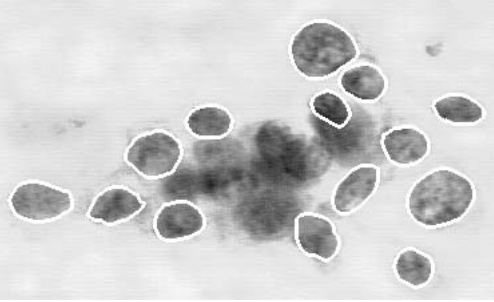


Für die oben dargestellten Nuclei wurden 10 verschiedene Features berechnet. Und für diese Features jeweils 3 statistische Maße: Mittelwert, Standardabweichung und Maximum der Nuclei, sodass am Ende 30 Features pro Bild vorhanden sind.
Mehr Informationen im Paper oder "wdbc.names".

[Paper zum Datensatz](https://www.researchgate.net/publication/2512520_Nuclear_Feature_Extraction_For_Breast_Tumor_Diagnosis)

Lade den Datensatz (wdbc.data und wdbc.names) in das Arbeitsverzeichnis.

In [ ]:
!unzip uebung7_daten.zip && mv uebung7_daten/* ./  && rmdir uebung7_daten


In [16]:
import pandas as pd

feature_names = ['f'+ str(i) for i in range(1,31)]
column_names = ['id','diagnosis'] + feature_names
data_breast = pd.read_csv('wdbc.data',header=None,names=column_names)

In [ ]:
data_breast

a) Visualisiere die Klassenverteilung anhand zweier Features mittels eines Scatterplots

b) *(Optional)* Berechne den besten Split mit der oben implementierten Funktion

c) Nutze den `DecisionTreeClassifier` (DT) aus sklearn um einen Baum mit Tiefe 3 und Minimum Samples/Blatt = 5 auf dem gesamten Datensatz zu berechnen. Die Bibliothek graphviz kann genutzt werden den Baum inline im Jupyter-Notebook zu visualisieren. Visualisiere den sich ergebenden Baum.

d) Nutze die Funktion `train_test_split` aus sklearn um Trainingsdaten und 20% Testdaten zu erzeugen. Trainiere den Entscheidungsbaum auf den Trainingsdaten und nutze die gegebenen Evaluierungsmaße mit `compute_eval` (implementiere diese weiter unten) um die Prädiktion auf den Testdaten zu beurteilen.

e) Was sind Vor- und Nachteile von Entscheidungsbäumen? Nenne jeweils zwei.

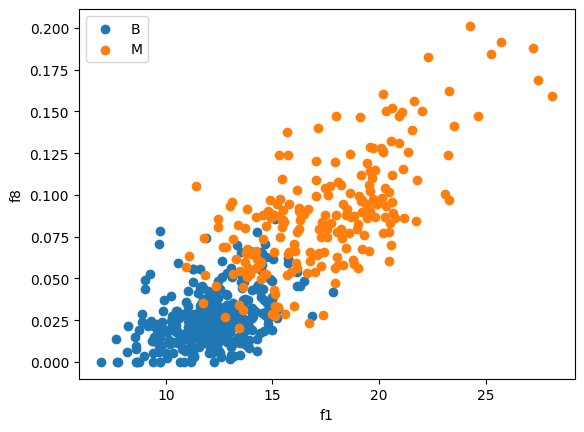

In [18]:
grouped = data_breast.groupby('diagnosis')
for name, group in grouped:
  plt.scatter(group['f1'],group['f8'],label=name)
plt.xlabel('f1')
plt.ylabel('f8')
plt.legend()

In [19]:
diagnosis = (data_breast['diagnosis']=='M').to_numpy().reshape(-1,1)
features = data_breast.iloc[:,2:].to_numpy()

In [ ]:
compute_best_split_cont(np.concatenate([features,diagnosis],axis=1))

In [ ]:
from sklearn import tree

dec_tree_vis = tree.DecisionTreeClassifier(max_depth=3,min_samples_leaf=5)
dec_tree_vis.fit(features,diagnosis.reshape(-1))


import graphviz
dot_data = tree.export_graphviz(dec_tree_vis, out_file=None,
                     feature_names=feature_names,
                     class_names=['B','M'],
                     filled=True, rounded=True,
                     special_characters=True)
graph = graphviz.Source(dot_data)
graph

Die Evaluierungsmaße sind bereits aus der Vorlesung "Bewertungskriterien für Klassifikatoren" bekannt. Implementiere den Rest der Funktion `comp_eval`.

In [22]:
def comp_eval(TP,TN,FP,FN):
  '''
  Berechnet Accuracy, Recall, Precision und F1 Score für die gegebenen True Positives,
  True Negatives, False Positives und False Negatives
  '''
  recall = TP/(TP+FN)
  precision = TP/(TP+FP)
  accuracy = (TP+TN)/(TP+TN+FP+FN)
  F1 = 2/(1/precision+1/recall)
  print('accuracy:',accuracy,', recall:',recall,', precision:',precision,', F1:',F1)

def compute_eval(y_pred,y_test):
  TP = np.logical_and(y_pred,y_test).sum()
  TN = np.logical_and(np.logical_not(y_pred),np.logical_not(y_test)).sum()
  FP = np.logical_and(y_pred,np.logical_not(y_test)).sum()
  FN = np.logical_and(np.logical_not(y_pred),y_test).sum()
  comp_eval(TP,TN,FP,FN)

In [ ]:
from sklearn.model_selection import train_test_split

random_state = np.random.RandomState(seed=42) # Wir wollen deterministisches Verhalten
X_train,X_test,y_train,y_test = train_test_split(features,diagnosis.reshape(-1),test_size=0.2,random_state=random_state)

# Achtung! Auch die DecisionTree Implementierung hat eine Random-Komponente mit Standardparametern!
dec_tree = tree.DecisionTreeClassifier(max_depth=3,min_samples_leaf=5)
dec_tree.fit(X_train,y_train)

y_pred = dec_tree.predict(X_test)

compute_eval(y_pred,y_test)

###Vorteile und Nachteile von Entscheidungsbäumen

+ (+) Einfach zu visualisieren und zu interpretieren: Die grafische Darstellung ist sehr intuitiv zu verstehen, und es sind keine statistischen Kenntnisse erforderlich (White-Box Model)
+ (+) Nützlich bei der Datenexploration: Mit einem Entscheidungsbaum können wir die wichtigste Variable und die Beziehung zwischen den Variablen leicht identifizieren. Er kann uns helfen, neue Variablen zu erstellen oder vorhandene zu gruppieren.
+ (+) Kaum Datenbereinigung erforderlich: Ziemlich robust gegen Ausreißer und fehlende Daten
+ (+) Regressions und Klassifikationsprobleme gleichermaßen abgebildet

- (-) Überanpassung: Ein einzelner Entscheidungsbaum neigt zur Überanpassung der Daten, was durch die Festlegung von Beschränkungen für die Modellparameter, d. h. die Tiefe des Baums und Pruning reduziert werden kann
- (-) Kleine Variationen in den Daten führen zu vollständig unterschiedlichen Bäumen. Deshalb nutzen wir Ensembles von Bäumen.
- (-) Es existieren Probleme, die nur schwierig abgebildet werden können (Beispiel: XOR)

## Aufgabe 2: Random Forest
In der Vorlesung wurde der Random Forest (RF) als Ensemble von Entscheidungsbäumen vorgestellt. Dieser soll die Robustheit der Entscheidungsbäume vergrößern.
Nutze den Random Forest Classifier um den Brustkrebs-Datensatz zu klassifizieren. Was stellst du fest im Vergleich zum Entscheidungsbaum?


In [24]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10,max_depth=30,bootstrap=True,min_samples_leaf=5, class_weight="balanced")
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

compute_eval(y_pred,y_test)

accuracy: 0.956140350877193 , recall: 0.9302325581395349 , precision: 0.9523809523809523 , F1: 0.9411764705882353


In diesem Fall funktioniert der Entscheidungsbaum bereits sehr gut und nur durch starke Parameteroptimierung kann das Ergebnis mit dem Random Forest noch verbessert werden. Deshalb wollen wir uns im nächsten Schritt einen etwas schwierigeren Datensatz ansehen.

## Aufgabe 3: Sepsis Prädiktion mit DT, RF oder XGBoost?

In der Physionet/CinC-Challenge 2019 war die Aufgabe die frühe Prädiktion von Sepsis auf der Basis von medizinischen Daten, die im allgemeinen auf der Intensivstation von Krankenhäusern anfallen ([Challenge-Paper](https://physionet.org/content/challenge-2019/1.0.0/physionet_challenge_2019_ccm_manuscript.pdf))
Sepsis (auch Blutvergiftung) ist ein lebensbedrohlicher Zustand, der entsteht, wenn körpereigene Abwehrreaktionen auf eine Infektion auch eigene Gewebe und Organe schädigen. Dieser entsteht unter anderem oft während Krankenhausaufenthalten.
Der Datensatz enthält eine Zeitreihe von Gesundheitsdaten von einer großen Zahl von Patienten.

a) Lade die Daten von physionet.org und inspiziere die vorhandenen Daten mit Pandas. Wie groß ist der Anteil der Sepsis-Patienten im Datensatz?

b) Ab hier betrachten wir nur noch den letzten Eintrag der Zeitreihe eines jeden Patienten. Fasse die Daten aller Patienten als ein numpy-ndarray zusammen. Trenne die Daten in Trainingsdaten und Testdaten. Nutze den Entscheidungsbaum und den Random Forest um Vorhersagen zu treffen. Wie schätzt du die Ergebnisse ein? Vergleiche die Klassifizierer. Nutze die Feature-Importance des RF und die Struktur des Baumes, sowie die in den vorherigen Aufgaben genutzten Maße um die Ergebnisse zu deuten. Was können wir über die Features aussagen?


*Tipp:* Nutze den `SimpleImputer` ([sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)) um die vielen NaN-Einträge sinnvoll zu ersetzen. Üblicherweise wählt man einen Wert, der in den Daten nicht vorkommt, als "missing"-Label oder den Mittelwert/Median der einzelnen Merkmale.


### Lade Daten direkt von Physionet.org (sehr langsam)

In [25]:
# unterdrückt Output #20643 recordings
%%capture
!wget -r -N -c -np https://physionet.org/files/challenge-2019/1.0.0/

### Verwende Daten aus Moodle (training_setA.zip)
Lade Daten aus Moodle herunter und hier hoch. Enpacke dann mit der folgenden Zelle das Zip-Verzeichnis.

In [ ]:
# Upload training_setA.zip manuell
%%capture
! unzip training_setA.zip && mv training_setA/training ./training && rmdir training_setA

In [32]:
import os, sys, pandas as pd

def load_all_pandas(folder):
  patients = list()
  files = os.listdir(folder)
  files.sort()
  for file in files:
    try:
      patients.append(pd.read_csv(os.path.join(folder,file),sep='|'))
    except:
      print('skipped file!')
  return patients

In [33]:
dfs = load_all_pandas('training')


In [ ]:
dfs[10]

In [35]:
final_day_df = pd.concat([df.tail(1) for df in dfs],ignore_index=True)


In [ ]:
n_sepsis = (final_day_df['SepsisLabel']==1).sum()
n_total = final_day_df.shape[0]
print('Personen mit Sepsis:',n_sepsis,'Anteil:',n_sepsis/n_total*100,'%')
final_day_df

In [ ]:
final_day_df[final_day_df['SepsisLabel']==1].mean()

In [ ]:
final_day_df[final_day_df['SepsisLabel']==1].std()

In [ ]:
final_day_df[final_day_df['SepsisLabel']==0].mean()

In [40]:
sepsis_feature_names = final_day_df.columns[:-1]
XY = final_day_df.to_numpy()
X = XY[:,:-1]
y = XY[:,-1]

Wir gehen sicher, dass wir das richtige Format und die richtige Anzahl an Patienten haben.

In [ ]:
print(y.shape)
print(X.shape)

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

random_state = np.random.RandomState(seed=42)

imp_m1 =  SimpleImputer(missing_values=np.nan, strategy='constant',fill_value=-1337)
imp_m1.fit(X)
X = imp_m1.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)


rf_class = RandomForestClassifier(n_estimators=100,max_depth=25,bootstrap=True,min_samples_leaf=4, class_weight="balanced", random_state=random_state, max_samples=0.7)
dt_class = tree.DecisionTreeClassifier(max_depth=5,min_samples_leaf=5)

rf_class.fit(X_train,y_train)
dt_class.fit(X_train,y_train)

y_pred_rf = rf_class.predict(X_test)
y_pred_dt = dt_class.predict(X_test)


In [ ]:
print('===Random Forest===')
compute_eval(y_pred_rf,y_test)
print('\n===Decision Tree===')
compute_eval(y_pred_dt,y_test)

In [ ]:
pd.DataFrame(rf_class.feature_importances_.reshape(1,-1),columns=sepsis_feature_names)

Offensichtlich besitzt die Dauer des Aufenthalts auf der Intensivstations(ICU, ICULOS) die höchste Vorhersageleistung. Könnte es sich hierbei einfach nur um Data-Leakage handeln?

In [ ]:
DT_vis = tree.export_graphviz(dt_class, out_file=None,
                     feature_names=sepsis_feature_names,
                     filled=True, rounded=True,
                     special_characters=True)
graph = graphviz.Source(DT_vis)
graph

Der Entscheidungsbaum gibt uns Aufschluss darüber, wie ICULOS einfließt. War ein Patient zwischen 60 und 300h auf der Intensivstation ist quasi sicher, dass er eine Sepsis hat/hatte. Nun ist es aber vermutlich so, dass der lange Aufenthalt gerade durch das Vorhandensein von Sepsis erklärt werden kann und womöglich zu der Entscheidung der Ärzte geführt hat.

Deshalb wollen wir uns das Ergebnis anschauen, wenn wir ICULOS als Merkmal ignorieren.

In [ ]:
random_state = np.random.RandomState(seed=42)

X_train, X_test, y_train, y_test = train_test_split(X[:,:-1], y, test_size=0.33, random_state=random_state)


rf_class = RandomForestClassifier(n_estimators=100,max_depth=25,bootstrap=True,min_samples_leaf=4, class_weight="balanced", random_state=random_state, max_samples=0.7)
dt_class = tree.DecisionTreeClassifier(max_depth=5,min_samples_leaf=5)

rf_class.fit(X_train,y_train)
dt_class.fit(X_train,y_train)

y_pred_rf = rf_class.predict(X_test)
y_pred_dt = dt_class.predict(X_test)

print('===Random Forest===')
compute_eval(y_pred_rf,y_test)
print('\n===Decision Tree===')
compute_eval(y_pred_dt,y_test)
print('\n===Einfaches Raten===')
compute_eval(np.random.random(size=y_test.shape)<0.09,y_test)


In [ ]:
DT_vis = tree.export_graphviz(dt_class, out_file=None,
                     feature_names=sepsis_feature_names[:-1],
                     filled=True, rounded=True,
                     special_characters=True)
graph = graphviz.Source(DT_vis)
graph

Ergebnis:
1. Der Random Forest liefert uns das robustere Modell (beide sind nicht wirklich gut, DT ist auf dem Level von Raten)
2. Die Merkmale scheinen sich bei Betrachtung des Entscheidungsbaums nicht gut zum Trennen der Klassen zu eignen. ICULOS führt vermutlich zu Data-Leakage.

*Zusatz:* Trainiere den XGBoost-Algorithmus auf den Daten

In der Vorlesung wurde der XGBoost-Algorithmus als sehr potentes Werkzeug vorgestellt. Dieser hat ihn vielen Machine-Learning Competitions (z.B. auf Kaggle) regelmäßig den besten Platz erreicht.
[Hier](https://xgboost.readthedocs.io/en/latest/python/python_intro.html) gibt es einen Einstiegspunkt für Python.

*Zusatz:* Versuche die Prädiktion eines der Verfahren zu verbessern.
Nutze ein anderes Featureset oder schaue dir die gesamten Daten an. Diese sind eigentlich als mehrere Messpunkte für jeden Probanden gegeben. Kannst du die Sepsis zu früheren Zeitpunkten vorhersagen? Nutze nur Messungen, bei denen der Großteil der Features tatsächlich gemessen wurde.


In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train,label=y_train,feature_names=sepsis_feature_names[:-1])
dtest = xgb.DMatrix(X_test,label=y_test,feature_names=sepsis_feature_names[:-1])
param = {'max_depth':20, 'eta':1, 'objective':'binary:logistic' }
param['eval_metric']= ['aucpr','auc']
num_round=10
evallist = [(dtest, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round,evallist,verbose_eval=True)

preds = bst.predict(dtest)
xgb.plot_importance(bst)

In [ ]:
print('===XGBoost===')
compute_eval(preds>0.5,y_test)

Zum Schluss:

Das prominente Paper ["Do We Need Hundreds of Classifiers to Solve Real World Classification Problems?"](http://jmlr.csail.mit.edu/papers/v15/delgado14a.html) veröffentlicht 2014 im Journal of Machine Learning Research untersuchte 179 Classifier aus 17 verschiedenen Gruppen auf 121 Standard-Datensätzen.

Das Ergebnis: Die Classifier aus der Familie der Random Forests erzielten die höchste Genauigkeit mit über 94% mittlerer relativer Genauigkeit bezogen auf die maximale Genauigkeit aller Classifier auf allen Datensätzen.